In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


### Upload your CSV file

Run the cell below to upload your CSV file. A file selection dialog will appear after running it.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rkiattisak/student-performance-in-mathematics")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-performance-in-mathematics' dataset.
Path to dataset files: /kaggle/input/student-performance-in-mathematics


In [ ]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  uploaded_df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))

print("\nSuccessfully loaded CSV into 'uploaded_df' DataFrame.")

Saving exams.csv to exams.csv
User uploaded file "exams.csv" with length 56903 bytes

Successfully loaded CSV into 'uploaded_df' DataFrame.


In [ ]:
display(uploaded_df.head())

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


Dataset shape: (1004, 8)
Columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


Train shape: (803, 7) Test shape: (201, 7)
Iteration 1, loss = 2343.55059669
Validation score: -16.897614
Iteration 2, loss = 2056.57678165
Validation score: -13.002134
Iteration 3, loss = 1248.00546726
Validation score: -3.837825
Iteration 4, loss = 253.71926261
Validation score: -0.018326
Iteration 5, loss = 93.74290526
Validation score: 0.476767
Iteration 6, loss = 60.00986662
Validation score: 0.610631
Iteration 7, loss = 47.52952243
Validation score: 0.669987
Iteration 8, loss = 40.42737683
Validation score: 0.713608
Iteration 9, loss = 36.11879997
Validation score: 0.738283
Iteration 10, loss = 32.61142631
Validation score: 0.759201
Iteration 11, loss = 29.82871995
Validation score: 0.775638
Iteration 12, loss = 27.53668317
Validation score: 0.786989
Iteration 13, loss = 25.73380855
Validation score: 0.800048
Iteration 14, loss = 24.18567977
Validation score: 0.808739
Iteration 15, loss = 23.08999249
Validation score: 0.815782
Iteration 16, loss = 22.16381704
Validation score: 0.

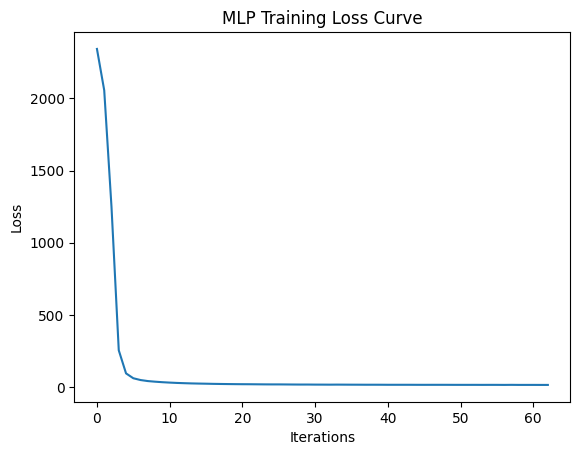


Example: True score=76, Predicted score=75.54


In [ ]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import joblib
import matplotlib.pyplot as plt

# Use the previously uploaded DataFrame
data = uploaded_df.copy()

print("Dataset shape:", data.shape)
print("Columns:", data.columns.tolist())
display(data.head())

# ✅ Encode categorical columns
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# ✅ Features and target (math score)
X = data.drop(columns=['math score'])
y = data['math score']

# ✅ Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ✅ Build and train Neural Network Regressor
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=32,
    learning_rate_init=1e-3,
    max_iter=300,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    verbose=True
)

mlp.fit(X_train, y_train)

# ✅ Evaluate performance
y_pred = mlp.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# ✅ Save model and encoders
out_dir = "/mnt/data/student_performance_regression"
os.makedirs(out_dir, exist_ok=True)
joblib.dump(mlp, os.path.join(out_dir, "student_mlp_regressor.joblib"))
joblib.dump(scaler, os.path.join(out_dir, "scaler.joblib"))
joblib.dump(label_encoders, os.path.join(out_dir, "label_encoders.joblib"))
print(f"\nModel and artifacts saved to: {out_dir}")

# ✅ Plot loss curve
if hasattr(mlp, "loss_curve_"):
    plt.figure()
    plt.plot(mlp.loss_curve_)
    plt.title("MLP Training Loss Curve")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

# ✅ Example prediction
idx = 0 # Changed from 5 to 0 because X_test has only 5 samples (indices 0-4)
sample_pred = mlp.predict(X_test[idx].reshape(1, -1))[0]
print(f"\nExample: True score={y_test.iloc[idx]}, Predicted score={sample_pred:.2f}")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = mlp.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")



📊 Model Evaluation Metrics:
Mean Absolute Error (MAE): 4.513
Mean Squared Error (MSE): 31.330
Root Mean Squared Error (RMSE): 5.597
R² Score: 0.863


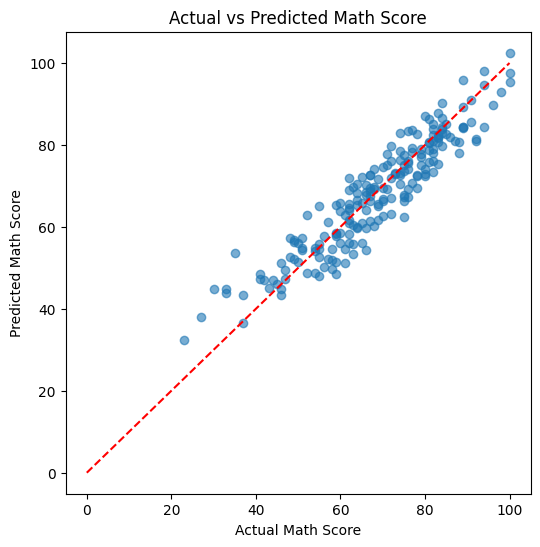

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0,100],[0,100],'r--')  # perfect prediction line
plt.xlabel("Actual Math Score")
plt.ylabel("Predicted Math Score")
plt.title("Actual vs Predicted Math Score")
plt.show()


In [ ]:
# Run this cell to predict a math score for a user sample
import os
import joblib
import numpy as np
import pandas as pd

# === Edit this path if you saved artifacts elsewhere ===
ARTIFACT_DIR = "/mnt/data/student_performance_regression"  # earlier out_dir
MODEL_FILE = os.path.join(ARTIFACT_DIR, "student_mlp_regressor.joblib")
SCALER_FILE = os.path.join(ARTIFACT_DIR, "scaler.joblib")
ENCODERS_FILE = os.path.join(ARTIFACT_DIR, "label_encoders.joblib")

# Load artifacts (if they exist)
if os.path.exists(MODEL_FILE) and os.path.exists(SCALER_FILE) and os.path.exists(ENCODERS_FILE):
    model = joblib.load(MODEL_FILE)
    scaler = joblib.load(SCALER_FILE)
    label_encoders = joblib.load(ENCODERS_FILE)
    print("Loaded model, scaler and label encoders from:", ARTIFACT_DIR)
else:
    raise FileNotFoundError(f"Model/scaler/encoders not found in {ARTIFACT_DIR}. "
                            "Check path or re-run training to save artifacts.")

# === Inspect categorical encoder categories (helpful to pick valid values) ===
print("\nCategorical encoder keys and classes:")
for k, le in label_encoders.items():
    try:
        print(f" - {k}: {list(le.classes_)}")
    except Exception:
        # if saved as dict of LabelEncoders, classes_ should exist
        print(f" - {k}: (cannot read classes_)")


sample = {
    "gender": "female",
    "race/ethnicity": "group B",
    "parental level of education": "bachelor's degree",
    "lunch": "standard",
    "test preparation course": "none",
    "reading score": 72,
    "writing score": 70
}

# === Convert to DataFrame with correct column order ===
feature_order = ['gender', 'race/ethnicity', 'parental level of education',
                 'lunch', 'test preparation course', 'reading score', 'writing score']
sample_df = pd.DataFrame([sample], columns=feature_order)

# === Encode categorical columns using saved label encoders ===
for col, le in label_encoders.items():
    if col in sample_df.columns:
        # verify value exists in encoder classes; if not, we can try to map to nearest or raise informative error
        val = str(sample_df.loc[0, col])
        if val not in list(le.classes_):
            raise ValueError(f"Value '{val}' not found in encoder for column '{col}'. "
                             f"Valid options: {list(le.classes_)}")
        sample_df[col] = le.transform([val])

# === Scale numeric features using saved scaler ===
X_sample_scaled = scaler.transform(sample_df.values)  # shape (1, n_features)

# === Predict using the loaded model ===
predicted_math_score = model.predict(X_sample_scaled)[0]

# === Simple categorical buckets for interpretation ===
def bucket(score):
    # adjust buckets as you prefer
    if score < 40:
        return "Low"
    elif score < 70:
        return "Medium"
    else:
        return "High"

print("\nUser sample (raw):")
print(sample_df)
print(f"\nPredicted math score: {predicted_math_score:.2f}")
print(f"Bucketed performance: {bucket(predicted_math_score)}")

# === Optional: if you want a confidence-ish interval from ensemble approach ---
# For single MLPRegressor there's no built-in probabilistic output. If you want uncertainty estimates,
# train an ensemble of models (or use Bayesian NN / dropout MC / quantile regression). ===

# === Example: Batch prediction ===
# To predict multiple samples, create a DataFrame with same columns and run the same encode/scale/predict pipeline.


Loaded model, scaler and label encoders from: /mnt/data/student_performance_regression

Categorical encoder keys and classes:
 - gender: ['female', 'male']
 - race/ethnicity: ['group A', 'group B', 'group C', 'group D', 'group E']
 - parental level of education: ["associate's degree", "bachelor's degree", 'high school', "master's degree", 'some college', 'some high school']
 - lunch: ['free/reduced', 'standard']
 - test preparation course: ['completed', 'none']

User sample (raw):
   gender  race/ethnicity  parental level of education  lunch  \
0       0               1                            1      1   

   test preparation course  reading score  writing score  
0                        1             72             70  

Predicted math score: 63.08
Bucketed performance: Medium


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Confusion Matrix:
[[ 3  5  0]
 [ 0 91  9]
 [ 0 10 83]]


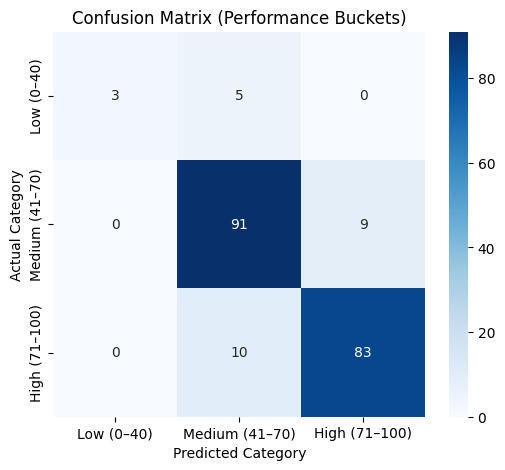


Classification Report:
                precision    recall  f1-score   support

    Low (0–40)       1.00      0.38      0.55         8
Medium (41–70)       0.86      0.91      0.88       100
 High (71–100)       0.90      0.89      0.90        93

      accuracy                           0.88       201
     macro avg       0.92      0.73      0.78       201
  weighted avg       0.88      0.88      0.88       201



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define bucket function ---
def bucketize(scores):
    if isinstance(scores, (pd.Series, np.ndarray, list)):
        return np.array([0 if s <= 40 else 1 if s <= 70 else 2 for s in scores])
    else:
        return 0 if scores <= 40 else 1 if scores <= 70 else 2

# Convert both actual and predicted values to categories
y_test_buckets = bucketize(y_test)
y_pred_buckets = bucketize(y_pred)

# --- Compute confusion matrix ---
cm = confusion_matrix(y_test_buckets, y_pred_buckets)
labels = ["Low (0–40)", "Medium (41–70)", "High (71–100)"]

print("Confusion Matrix:")
print(cm)

# --- Display as heatmap ---
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix (Performance Buckets)")
plt.show()

# --- Classification report ---
print("\nClassification Report:")
print(classification_report(y_test_buckets, y_pred_buckets, target_names=labels))


TRAIN SET
Accuracy: 0.8804

                precision    recall  f1-score   support

    Low
(0–40)     0.8571    0.6857    0.7619        35
Medium
(41–70)     0.8870    0.8828    0.8849       418
 High
(71–100)     0.8747    0.8971    0.8858       350

      accuracy                         0.8804       803
     macro avg     0.8729    0.8219    0.8442       803
  weighted avg     0.8803    0.8804    0.8799       803


TEST SET
Accuracy: 0.8806

                precision    recall  f1-score   support

    Low
(0–40)     1.0000    0.3750    0.5455         8
Medium
(41–70)     0.8585    0.9100    0.8835       100
 High
(71–100)     0.9022    0.8925    0.8973        93

      accuracy                         0.8806       201
     macro avg     0.9202    0.7258    0.7754       201
  weighted avg     0.8843    0.8806    0.8764       201



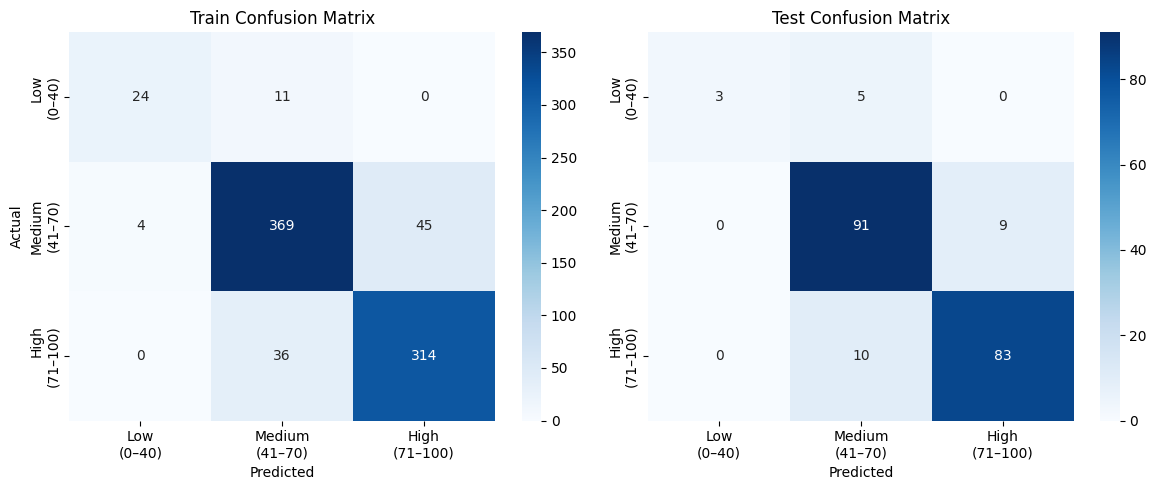

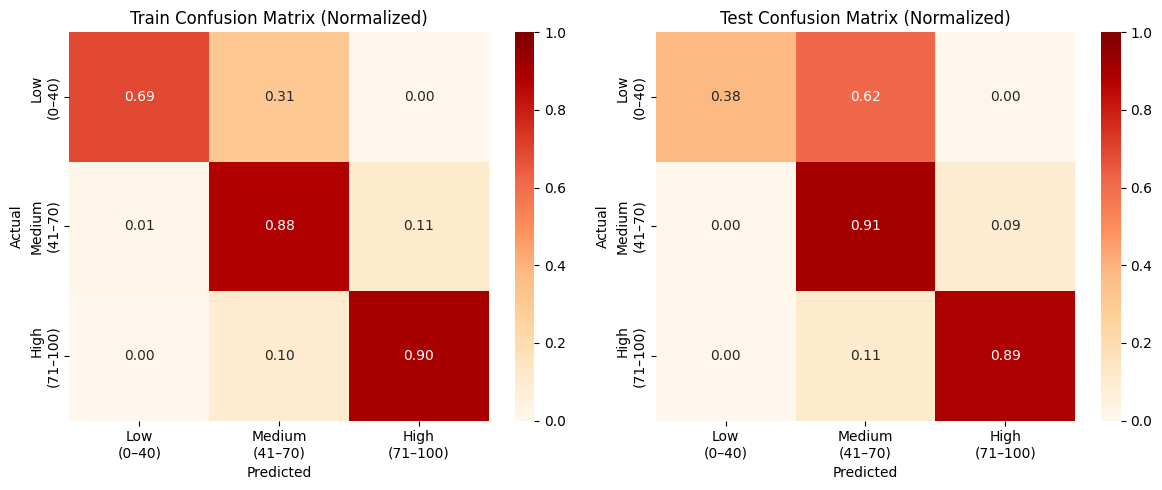

In [ ]:
# Train & Test Confusion Matrices (side-by-side)
# Paste and run in the same environment where you trained the model.
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Helper: bucketize continuous scores into categories 0=Low,1=Medium,2=High
def bucketize_array(arr):
    arr = np.array(arr)
    return np.where(arr <= 40, 0, np.where(arr <= 70, 1, 2))

# --- Try to use existing objects in the notebook; otherwise load artifacts
need_load = False
try:
    mlp, X_train, X_test, y_train, y_test
except NameError:
    need_load = True

if need_load:
    ARTIFACT_DIR = "/mnt/data/student_performance_regression"
    model_file = os.path.join(ARTIFACT_DIR, "student_mlp_regressor.joblib")
    scaler_file = os.path.join(ARTIFACT_DIR, "scaler.joblib")
    encoders_file = os.path.join(ARTIFACT_DIR, "label_encoders.joblib")
    if not os.path.exists(model_file):
        raise FileNotFoundError(f"Model not found at {model_file}. Run training or point ARTIFACT_DIR to correct folder.")
    mlp = joblib.load(model_file)

    # Attempt to load the pre-scaled train/test split saved earlier isn't available;
    # we'll recreate X/y from CSV if necessary
    csv_folder = "/root/.cache/kagglehub/datasets/rkiattisak/student-performance-in-mathematics/versions/3"
    import glob, pandas as pd
    csvs = glob.glob(os.path.join(csv_folder, "**", "*.csv"), recursive=True)
    if not csvs:
        raise FileNotFoundError(f"No CSV found under {csv_folder}.")
    df = pd.read_csv(csvs[0])
    # encode with saved encoders if present
    if os.path.exists(encoders_file):
        label_encoders = joblib.load(encoders_file)
        for col, le in label_encoders.items():
            if col in df.columns:
                df[col] = le.transform(df[col].astype(str))
    else:
        # fallback: simple label encoding
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = pd.factorize(df[col])[0]
    # target and features (math score)
    X_all = df.drop(columns=['math score']).values
    y_all = df['math score'].values
    # scale with saved scaler if present
    if os.path.exists(scaler_file):
        scaler = joblib.load(scaler_file)
        X_all_scaled = scaler.transform(X_all)
    else:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_all_scaled = scaler.fit_transform(X_all)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_all_scaled, y_all, test_size=0.2, random_state=42)

# --- Predict (continuous)
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

# --- Bucketize to categories
y_train_b = bucketize_array(y_train)
y_test_b  = bucketize_array(y_test)
y_train_pred_b = bucketize_array(y_train_pred)
y_test_pred_b  = bucketize_array(y_test_pred)

# --- Confusion matrices
cm_train = confusion_matrix(y_train_b, y_train_pred_b)
cm_test  = confusion_matrix(y_test_b,  y_test_pred_b)

labels = ["Low\n(0–40)", "Medium\n(41–70)", "High\n(71–100)"]

# --- Print accuracies and classification reports
print("TRAIN SET")
print(f"Accuracy: {accuracy_score(y_train_b, y_train_pred_b):.4f}\n")
print(classification_report(y_train_b, y_train_pred_b, target_names=labels, digits=4))

print("\nTEST SET")
print(f"Accuracy: {accuracy_score(y_test_b, y_test_pred_b):.4f}\n")
print(classification_report(y_test_b, y_test_pred_b, target_names=labels, digits=4))

# --- Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=labels, yticklabels=labels)
axes[0].set_title("Train Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=labels, yticklabels=labels)
axes[1].set_title("Test Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

# --- Also show normalized (row-wise) confusion matrices to inspect recall per class
def plot_normalized(cm, ax, title):
    row_sums = cm.sum(axis=1, keepdims=True)
    norm = cm.astype('float') / np.where(row_sums==0, 1, row_sums)
    sns.heatmap(np.round(norm, 2), annot=True, fmt='.2f', cmap='OrRd', ax=ax,
                xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

fig2, axes2 = plt.subplots(1,2, figsize=(12,5))
plot_normalized(cm_train, axes2[0], "Train Confusion Matrix (Normalized)")
plot_normalized(cm_test, axes2[1], "Test Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()


In [ ]:
import os
import joblib

# Directory where we'll save everything
SAVE_DIR = "/mnt/data/student_performance_regression"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save trained model, scaler, and label encoders
joblib.dump(mlp, os.path.join(SAVE_DIR, "student_mlp_regressor.joblib"))
joblib.dump(scaler, os.path.join(SAVE_DIR, "scaler.joblib"))
joblib.dump(label_encoders, os.path.join(SAVE_DIR, "label_encoders.joblib"))

print(f"✅ Model and preprocessing artifacts saved successfully in:\n{SAVE_DIR}")
print("\nFiles created:")
print(" - student_mlp_regressor.joblib  (Trained NN model)")
print(" - scaler.joblib                  (StandardScaler for feature normalization)")
print(" - label_encoders.joblib          (Categorical encoders)")


✅ Model and preprocessing artifacts saved successfully in:
/mnt/data/student_performance_regression

Files created:
 - student_mlp_regressor.joblib  (Trained NN model)
 - scaler.joblib                  (StandardScaler for feature normalization)
 - label_encoders.joblib          (Categorical encoders)


In [ ]:
import joblib

LOAD_DIR = "/mnt/data/student_performance_regression"

model = joblib.load(os.path.join(LOAD_DIR, "student_mlp_regressor.joblib"))
scaler = joblib.load(os.path.join(LOAD_DIR, "scaler.joblib"))
label_encoders = joblib.load(os.path.join(LOAD_DIR, "label_encoders.joblib"))

print("✅ Model and preprocessing tools loaded successfully.")


✅ Model and preprocessing tools loaded successfully.


In [ ]:
import os
os.listdir("/mnt/data/student_performance_regression")


['label_encoders.joblib', 'student_mlp_regressor.joblib', 'scaler.joblib']